In [5]:
import sys
from glob import glob
import pandas as pd
import numpy as np
import itertools as it 
import matplotlib.pyplot as plt
from scipy.special import comb

sys.path.append('../')
sys.path.append('/rumi/shams/abe/Projects/ipage-down/')
# sys.path.append("/Users/abearab/Documents/UCSF/ipage-down/")

from util import *
import ipage_down as ipd

# wd='/Users/abearab/Documents/UCSF/Decitabine Project/Decitabine-treatment'
wd='/rumi/shams/abe/Projects/Decitabine-treatment/'

Here, I aim to do _hyper-geometric test_ on enriched genesets (iPAGE results) in CRISPR screening experiment (Rho scores) to test hyper/hypo methylation enrichment. 

### Load data

Load `hl60` CRISPRi-screen data

In [6]:
data = load_data(screens=True,wd=wd)
# data = load_data(screens=True)

In [7]:
data['hl60'].keys()

dict_keys(['exp1_DAC_rho', 'exp1_DAC_gamma', 'exp2_DAC_rho', 'exp2_DAC_gamma', 'exp2_GSK_rho', 'exp2_GSK_gamma'])

Load iPAGE results (`_dependence0` for comparing two biological replicates) into python - using my [ipage-down](https://github.com/abearab/ipage-down) python script 

In [9]:
# PAGE = dict([[f.split('/')[2].replace('_delta_phenotype_independence0',''),ipd.make_ipage_run_data_frame(f)] for f in glob('../CRISPRi-screen/*independence0/')])

# cons_pws = set(PAGE['hl60_exp1_DAC_rho'].index.to_frame().gene_set.to_list()).intersection(
#     set(PAGE['hl60_exp2_DAC_rho'].index.to_frame().gene_set.to_list()))

# PAGE_filtered = dict([[exp, PAGE[exp].loc[cons_pws]] for exp in PAGE ])

# ann = ipd.make_annotation_dict(PAGE_filtered['hl60_exp1_DAC_rho'])

# df = pd.concat([PAGE_filtered['hl60_exp1_DAC_rho'],PAGE_filtered['hl60_exp2_DAC_rho']],axis=1)

# screen_up = df[
#     (np.sum(df.iloc[:,[1,3]] >= 2,axis=1) == 2) & (np.sum(df.iloc[:,[0,2]] <= 0,axis=1) == 2)
# ].sort_values(by=['[0.08 0.97]','[0.14 1.00]'],ascending=False).style.background_gradient(cmap='coolwarm',axis=None,vmin=-2,vmax=2)

# screen_dn = df[
#     (np.sum(df.iloc[:,[0,2]] > 2,axis=1) == 2) & (np.sum(df.iloc[:,[1,3]] <= 0,axis=1) == 2)
# ].sort_values(by=['[0.08 0.97]','[0.14 1.00]'],ascending=False).style.background_gradient(cmap='coolwarm',axis=None,vmin=-2,vmax=2)

In [10]:
# screen_up#.index.to_frame().gene_set.to_list()

In [11]:
# screen_dn#.index.to_frame().gene_set.to_list()

In [23]:
PAGE = ipd.make_ipage_run_data_frame(glob('../CRISPRi-screen/hl60_exp1_DAC_rho_delta_phenotype/')[0])

In [27]:
PAGE.style.background_gradient(cmap='coolwarm',axis=None,vmin=-2,vmax=2)

,,[-0.63 -0.10],[0.09 0.97]
gene_set,gs_cluster,,
HALLMARK_MYC_TARGETS_V1,human_h_gs,4.581000,2.023000
GO_TRANSLATIONAL_TERMINATION,human_c5_gs,-2.433000,13.304000
GO_ATPASE_COMPLEX,human_c5_gs,3.688000,2.328000
GO_TRNA_WOBBLE_URIDINE_MODIFICATION,human_c5_gs,-0.621000,7.124000
GO_REGULATION_OF_CYTOPLASMIC_TRANSLATION,human_c5_gs,-0.260000,6.774000
GO_THIOESTER_BIOSYNTHETIC_PROCESS,human_c5_gs,-0.782000,5.418000
GO_PROTEIN_K11_LINKED_UBIQUITINATION,human_c5_gs,3.510000,0.370000
GO_SPLICEOSOMAL_COMPLEX,human_c5_gs,1.239000,5.035000
GO_CHROMOSOME_CENTROMERIC_REGION,human_c5_gs,1.757000,4.736000


In [70]:
idx=pd.IndexSlice
ann = ipd.make_annotation_dict(PAGE.loc[idx[:,['human_c2_gs','human_c5_gs','human_h_gs']],])

### Run the hypergeom test





For this matter, we have:

    ○ N = # of all genes 
    ○ n/A = # of metylated genes OR enriched pathway's genes 
    ○ x = # of genes in n and A overlap 

https://github.com/JohnDeJesus22/DataScienceMathFunctions/blob/master/hypergeometricfunctions.py#L38

In [71]:
def hypergeom_pmf(N, A, n, x):
    '''
    Probability Mass Function for Hypergeometric Distribution
    :param N: population size
    :param A: total number of desired items in N
    :param n: number of draws made from N
    :param x: number of desired items in our draw of n items
    :returns: PMF computed at x
    '''
    Achoosex = comb(A,x)
    NAchoosenx = comb(N-A, n-x)
    Nchoosen = comb(N,n)
    
    return (Achoosex)*NAchoosenx/Nchoosen
    
    
def hypergeom_plot(N, A, n):
    '''
    Visualization of Hypergeometric Distribution for given parameters
    '''
    x = np.arange(0, n+1)
    y = [hypergeom_pmf(N, A, n, x) for x in range(n+1)]
    plt.plot(x, y, 'bo')
    plt.vlines(x, 0, y, lw=2)
    plt.xlabel('# of desired items in our draw')
    plt.ylabel('Probablities')
    plt.title('Hypergeometric Distribution Plot')
    plt.show()


def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 


def hypergeom_pw(pw,hyper, hypo):
    '''
    Run Hypergeometric test for given pathway
    '''
    res = list()
    for mtyl in [hyper, hypo]:
        N = 20000
        A = len(mtyl)
        n = len(pw)
        x = len(intersection(mtyl, pw))
        res.append(hypergeom_pmf(N, A, n, x))
    return res 


def run_hypergeom(ann):
    '''
    Return Hypergeometric test for all pathways in a ipage run 
    '''
    hyper, hypo = [set(list(mtyl.name)) for mtyl in two_sided_mtyl(wd=wd)]

    res = [ [pw,hypergeom_pw(ann[pw]['genes'],hyper, hypo)] for pw in ann ]
    res = pd.DataFrame([r[1] for r in res],columns=['hyper', 'hypo'],index=[r[0] for r in res]).dropna()
    return res 
#     res_dn = [
#         [pw,hypergeom_pw(ann[pw]['genes'],hyper, hypo)]
#         for pw in screen_dn.index.to_frame().gene_set.to_list()
#         if pw in ann 
#     ]

#     dfs = []
#     for res in [res_up, res_dn]:
#         dfs.append(pd.DataFrame([r[1] for r in res],columns=['hyper', 'hypo'],index=[r[0] for r in res]).dropna())
    
#     up, dn = dfs
#     return up, dn

In [77]:
res = run_hypergeom(ann)#.sort_values(['hyper','hypo'])

/rumi/shams/abe/anaconda3/envs/down-go/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/rumi/shams/abe/anaconda3/envs/down-go/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  


In [73]:
# res.sort_values(by='hypo',ascending=False).style.background_gradient(cmap='coolwarm',axis=None,vmin=0,vmax=0.5)

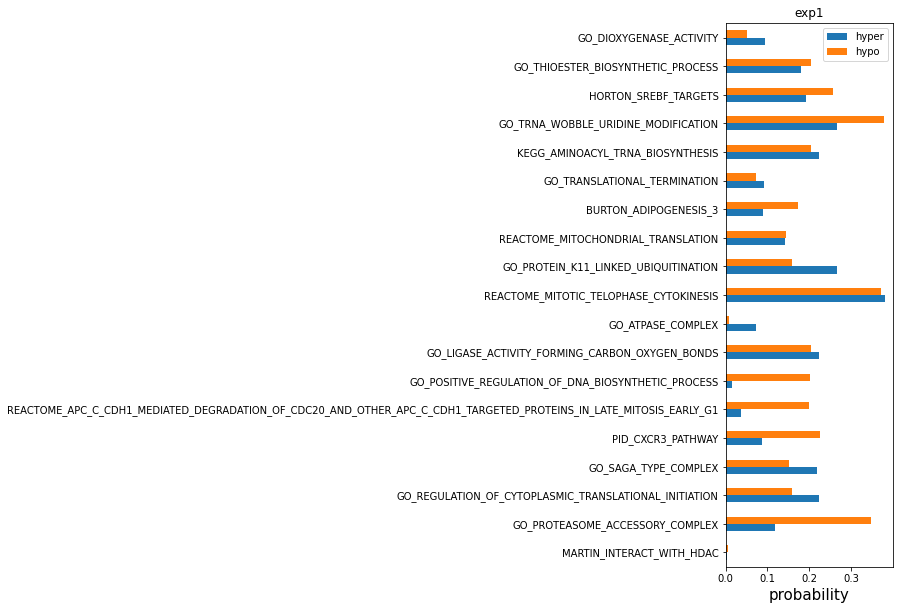

In [80]:
fig, ax = plt.subplots(figsize=(3, 10))
res.plot.barh(title='exp1',ax=ax)
# plt.sca(ax)
ax.set_xlabel('probability')
ax.xaxis.label.set_size(15)
fig.savefig("hyper-geometric-test.pdf", bbox_inches='tight')
plt.show()

## All enriched pathways 

In [42]:
# fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(50,30))

# plot1 = res1[0].plot.barh(title='exp1, enriched at high rho (Resistance)\n',ax=axes[0,1])

# plot2 = res1[1].plot.barh(title='exp1, enriched at low rho (Sensitivity)\n',ax=axes[0,0])

# plot3 = res2[0].plot.barh(title='exp2, enriched at high rho (Resistance)\n',ax=axes[1,1])

# plot4 = res2[1].plot.barh(title='exp2, enriched at low rho (Sensitivity)\n',ax=axes[1,0])


# plt.suptitle('Probability for presence of hypo/hyper methylated genes in\nenriched pathways at DAC-treatment CRISPRi-screen\n(Hypergeometric test)\n\n',size=24)
# for ax in fig.axes:
#     plt.sca(ax)
#     ax.set_xlabel('probability')
#     plt.yticks(rotation=45)

# plt.show()
# fig.savefig("hyper-geometric-test.pdf", bbox_inches='tight')

## Check intersectional genes presence in enriched pathways

In [16]:
def check_genes(page, genes):

    pvs = [page[gs]['pvmatrix'] for gs in page]

    res_up = [
        [gs,pw,gene]
        for pv, gs in zip(pvs,page)
        for pw in pv.index[pv.iloc[:,10] >= 2].to_list() 
        if pw in page[gs]['annotations'].keys()
        for gene in page[gs]['annotations'][pw]['genes']
        if gene in genes
    ]
    for res in res_up: 
        if len(res) > 0: 
            print ('high rho (Resistance)')
            print (res)
    
    res_dn = [
        [gs,pw,gene]
        for pv, gs in zip(pvs,page)
        for pw in pv.index[pv.iloc[:,0] >= 2].to_list() 
        if pw in page[gs]['annotations'].keys()
        for gene in page[gs]['annotations'][pw]['genes']
        if gene in genes
    ]
    for res in res_up: 
        if len(res) > 0: 
            print ('lwo rho (Sensitivity)')
            print (res)
    
    print ('\n')
#     dfs = []
#     for res in [res_up, res_dn]:
#         dfs.append(pd.DataFrame([r[1] for r in res],columns=['hyper', 'hypo'],index=[r[0] for r in res]).dropna())
    
#     up, dn = dfs
    
#     return up, dn

In [17]:
for i,genes in enumerate ([
    ['CEP152', 'MAP1S', 'MBD6'], 
    ['CYLD', 'MCL1', 'TTC14', 'APLP2', 'MTF1', 'PGD', 'RGS19', 'UBXN7']
]):
    Interactions = [
        'Rho_up & Exp_down & Hyper_m6A',
        'Rho_down & Exp_down & Hyper_m6A'
    ]
    
    print (Interactions[i])
    
    for exp in [
        'exp1_DAC_rho_page'
        ,
        'exp2_DAC_rho_page'
    ]:
        page = data['hl60'][exp]
        print (exp)
        check_genes(page, genes)

Rho_up & Exp_down & Hyper_m6A
exp1_DAC_rho_page
high rho (Resistance)
['human_c2_gs', 'REACTOME_MITOTIC_G2_G2_M_PHASES', 'CEP152']
high rho (Resistance)
['human_c7_gs', 'GSE6259_BCELL_VS_CD4_TCELL_UP', 'MBD6']
lwo rho (Sensitivity)
['human_c2_gs', 'REACTOME_MITOTIC_G2_G2_M_PHASES', 'CEP152']
lwo rho (Sensitivity)
['human_c7_gs', 'GSE6259_BCELL_VS_CD4_TCELL_UP', 'MBD6']


exp2_DAC_rho_page
high rho (Resistance)
['human_c7_gs', 'GSE12366_GC_VS_MEMORY_BCELL_UP', 'CEP152']
high rho (Resistance)
['human_c2_gs', 'MOREAUX_MULTIPLE_MYELOMA_BY_TACI_DN', 'CEP152']
high rho (Resistance)
['human_c2_gs', 'MOREAUX_B_LYMPHOCYTE_MATURATION_BY_TACI_DN', 'CEP152']
lwo rho (Sensitivity)
['human_c7_gs', 'GSE12366_GC_VS_MEMORY_BCELL_UP', 'CEP152']
lwo rho (Sensitivity)
['human_c2_gs', 'MOREAUX_MULTIPLE_MYELOMA_BY_TACI_DN', 'CEP152']
lwo rho (Sensitivity)
['human_c2_gs', 'MOREAUX_B_LYMPHOCYTE_MATURATION_BY_TACI_DN', 'CEP152']


Rho_down & Exp_down & Hyper_m6A
exp1_DAC_rho_page
high rho (Resistance)
['human_

## Common enriched pathways between two replicates:

In [12]:
pws_up = list(set(res1[0].index) & set(res2[0].index))
pws_dn = list(set(res1[1].index) & set(res2[1].index))

res = [
    res1[0].loc[pws_up,].sort_values(['hyper','hypo']),
    res1[1].loc[pws_dn,].sort_values(['hyper','hypo'])
]

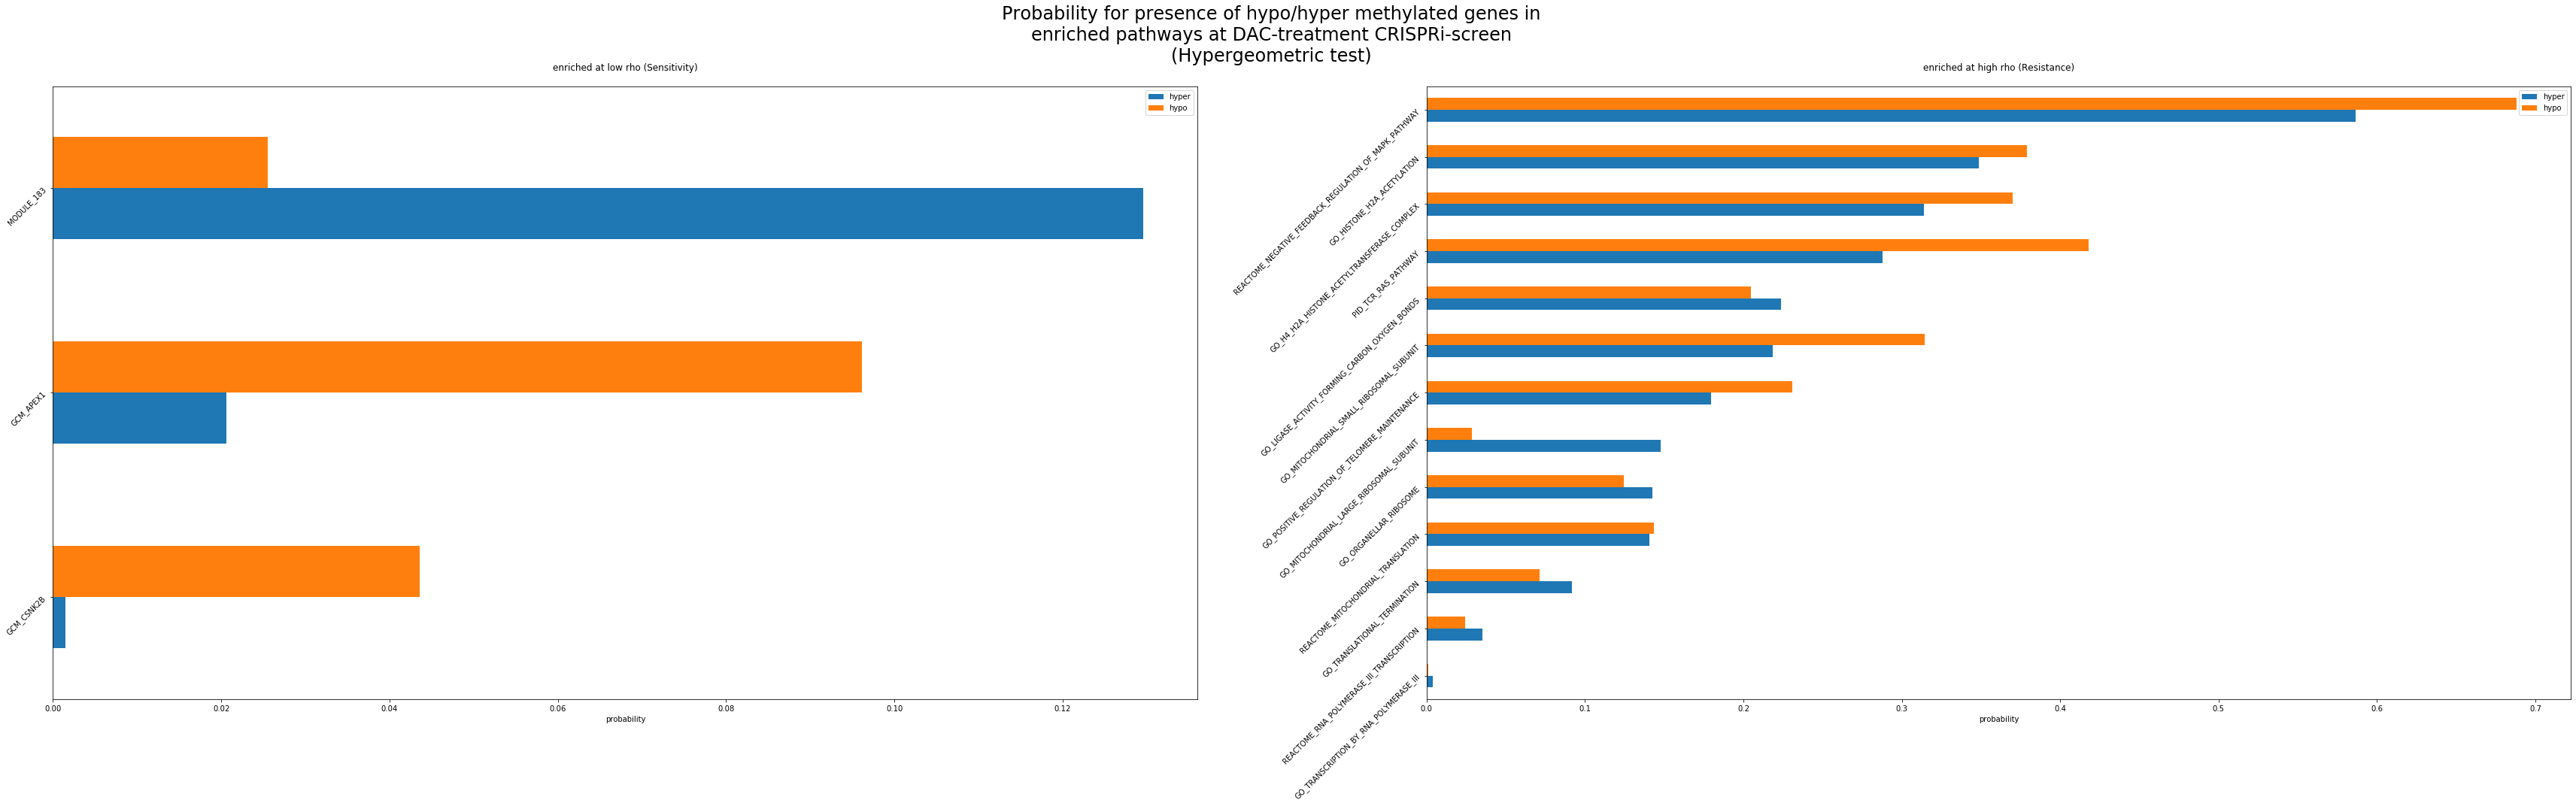

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(60,15))

plot1 = res[0].plot.barh(title='enriched at high rho (Resistance)\n',ax=axes[1])

plot2 = res[1].plot.barh(title='enriched at low rho (Sensitivity)\n',ax=axes[0])

plt.suptitle('Probability for presence of hypo/hyper methylated genes in\nenriched pathways at DAC-treatment CRISPRi-screen\n(Hypergeometric test)\n\n',size=24)
for ax in fig.axes:
    plt.sca(ax)
    ax.set_xlabel('probability')
    plt.yticks(rotation=45)

plt.show()
fig.savefig("hyper-geometric-test-common-pws.pdf", bbox_inches='tight')

In [19]:
def check_genes_common_pws(page, genes, pws_up,pws_dn):
    
    pvs = [page[gs]['pvmatrix'] for gs in page]

    res_up = [
        [gs,pw,gene]
        for pv, gs in zip(pvs,page)
        for pw in pv.index[pv.iloc[:,10] >= 2].to_list() 
        if pw in pws_up
        for gene in page[gs]['annotations'][pw]['genes']
        if gene in genes
    ]
    for res in res_up: 
        if len(res) > 0: 
            print ('high rho (Resistance)')
            print (res)
    
    res_dn = [
        [gs,pw,gene]
        for pv, gs in zip(pvs,page)
        for pw in pv.index[pv.iloc[:,0] >= 2].to_list() 
        if pw in pws_dn
        for gene in page[gs]['annotations'][pw]['genes']
        if gene in genes
    ]
    for res in res_up: 
        if len(res) > 0: 
            print ('lwo rho (Sensitivity)')
            print (res)
    
    print ('\n')
#     dfs = []
#     for res in [res_up, res_dn]:
#         dfs.append(pd.DataFrame([r[1] for r in res],columns=['hyper', 'hypo'],index=[r[0] for r in res]).dropna())
    
#     up, dn = dfs
    
#     return up, dn

In [20]:
for i,genes in enumerate ([
    ['DDX19A', 'RBFA', 'MRPL17', 'EIF4G1', 'TTI1', 'POLR1C', 'PREB', 'KLF16', 'UHRF1', 'GEMIN4'],
    ['MECR', 'FDFT1', 'TTI1', 'NUDCD3', 'ELP5', 'MIOS', 'KLF16', 'ZNF787'],
    ['CEP152', 'MAP1S', 'MBD6'],
    ['PTCD1', 'ZNF830', 'SHOC2', 'ZC3H13', 'MANBA', 'DENND1A'],
    ['NSUN2', 'ZNF514', 'SQLE', 'DDX6', 'DHODH', 'RBM14-RBM4', 'CCP110', 'PPRC1'],
    ['UCK2', 'ZNF514', 'ELAVL1', 'ZBTB9', 'PPRC1'],
    ['CYLD', 'MCL1', 'TTC14', 'APLP2', 'MTF1', 'PGD', 'RGS19', 'UBXN7'],
    ['SGMS1', 'GPR183', 'FPR2', 'CFLAR', 'ACBD3', 'MTF1', 'SLC44A2', 'NFKBIA'],
]):
    Interactions = [
        'Rho_up & Exp_up & Hyper_m6A',
        'Rho_up & Exp_up & Hypo_m6A',
        'Rho_up & Exp_down & Hyper_m6A',
        'Rho_up & Exp_down & Hypo_m6A',
        'Rho_down & Exp_up & Hyper_m6A',
        'Rho_down & Exp_up & Hypo_m6A',
        'Rho_down & Exp_down & Hyper_m6A',
        'Rho_down & Exp_down & Hypo_m6A'
    ]
    
    print (Interactions[i])
    
    for exp in [
        'exp1_DAC_rho_page'
        ,
        'exp2_DAC_rho_page'
    ]:
        page = data['hl60'][exp]

    check_genes_common_pws(page, genes, pws_up,pws_dn)

Rho_up & Exp_up & Hyper_m6A
high rho (Resistance)
['human_c5_gs', 'GO_TRANSLATIONAL_TERMINATION', 'MRPL17']
high rho (Resistance)
['human_c5_gs', 'GO_ORGANELLAR_RIBOSOME', 'MRPL17']
high rho (Resistance)
['human_c5_gs', 'GO_MITOCHONDRIAL_LARGE_RIBOSOMAL_SUBUNIT', 'MRPL17']
high rho (Resistance)
['human_c5_gs', 'GO_TRANSCRIPTION_BY_RNA_POLYMERASE_III', 'POLR1C']
high rho (Resistance)
['human_c2_gs', 'REACTOME_MITOCHONDRIAL_TRANSLATION', 'MRPL17']
high rho (Resistance)
['human_c2_gs', 'REACTOME_RNA_POLYMERASE_III_TRANSCRIPTION', 'POLR1C']
lwo rho (Sensitivity)
['human_c5_gs', 'GO_TRANSLATIONAL_TERMINATION', 'MRPL17']
lwo rho (Sensitivity)
['human_c5_gs', 'GO_ORGANELLAR_RIBOSOME', 'MRPL17']
lwo rho (Sensitivity)
['human_c5_gs', 'GO_MITOCHONDRIAL_LARGE_RIBOSOMAL_SUBUNIT', 'MRPL17']
lwo rho (Sensitivity)
['human_c5_gs', 'GO_TRANSCRIPTION_BY_RNA_POLYMERASE_III', 'POLR1C']
lwo rho (Sensitivity)
['human_c2_gs', 'REACTOME_MITOCHONDRIAL_TRANSLATION', 'MRPL17']
lwo rho (Sensitivity)
['human_c2_gs

# Conclusion:
form **Rho_up & Exp_down & Hyper_m6A**:
- CEP152
    - REACTOME_MITOTIC_G2_G2_M_PHASES
    - high rho (Resistance)
        - GSE12366_GC_VS_MEMORY_BCELL_UP
        - MOREAUX_MULTIPLE_MYELOMA_BY_TACI_DN
        - MOREAUX_B_LYMPHOCYTE_MATURATION_BY_TACI_DN

or maybe
- MBD6
    - GSE6259_BCELL_VS_CD4_TCELL_UP

    - lwo rho (Sensitivity)
        - GSE12366_GC_VS_MEMORY_BCELL_UP
        - MOREAUX_MULTIPLE_MYELOMA_BY_TACI_DN
        - MOREAUX_B_LYMPHOCYTE_MATURATION_BY_TACI_DN

____
form **Rho_down & Exp_down & Hyper_m6A**:
- PGD
    - CHIANG_LIVER_CANCER_SUBCLASS_UNANNOTATED_DN
    - GSE15930_NAIVE_VS_48H_IN_VITRO_STIM_CD8_TCELL_DN
    
    - high rho (Resistance)
        - BOYAULT_LIVER_CANCER_SUBCLASS_G3_UP
        - CHIANG_LIVER_CANCER_SUBCLASS_UNANNOTATED_DN
    - lwo rho (Sensitivity)
        - BOYAULT_LIVER_CANCER_SUBCLASS_G3_UP
        - CHIANG_LIVER_CANCER_SUBCLASS_UNANNOTATED_DN

or maybe one of 
- MTF1
    - high rho (Resistance)
        - REACTOME_ACTIVATION_OF_GENE_EXPRESSION_BY_SREBF_SREBP
    - lwo rho (Sensitivity)
        - REACTOME_ACTIVATION_OF_GENE_EXPRESSION_BY_SREBF_SREBP
- MCL1
    - PICCALUGA_ANGIOIMMUNOBLASTIC_LYMPHOMA_DN

- APLP2
    - GSE44649_NAIVE_VS_ACTIVATED_CD8_TCELL_MIR155_KO_UP
    - GSE15750_DAY6_VS_DAY10_TRAF6KO_EFF_CD8_TCELL_UP', 'APLP2']

- RGS19
    - high rho (Resistance)
        - GSE17721_POLYIC_VS_GARDIQUIMOD_12H_BMDC_DN
    - lwo rho (Sensitivity)
        - GSE17721_POLYIC_VS_GARDIQUIMOD_12H_BMDC_DN


____
from **Rho_up & Exp_up & Hyper_m6A**:
- POLR1C
    - GO_TRANSCRIPTION_BY_RNA_POLYMERASE_III
    - REACTOME_RNA_POLYMERASE_III_TRANSCRIPTION

or maybe
- MRPL17
    - GO_TRANSLATIONAL_TERMINATION
    - GO_ORGANELLAR_RIBOSOME
    - GO_MITOCHONDRIAL_LARGE_RIBOSOMAL_SUBUNIT
    - REACTOME_MITOCHONDRIAL_TRANSLATION